<a href="https://colab.research.google.com/github/Requiem5032/mcs-applied-ai/blob/dcgan/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN MNIST

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  999


## Inputs

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 28x28. If another size is desired,
   the structures of D and G must be changed.
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs

In [ ]:
# Root directory for dataset
dataroot = 'data/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28 #64

# Number of channels in the training images. For color images this is 3
nc = 1 #3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data

In this tutorial we will use the MNIST dataset from torchvision.

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.MNIST(root=dataroot, transform=transforms.ToTensor(), download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Done...")


Done...


In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf*4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 3 x 3
            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf*2, ngf, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 3, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(ndf*4, 1, 4, 2, 1, bias=False),
            #nn.Sigmoid() # not needed with nn.BCEWithLogitsLoss()
        )

    def forward(self, input):
        return self.main(input)

## Training

In [ ]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
def training_loop(num_epochs=num_epochs):

    ## Create the generator
    netG = Generator(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netG.apply(weights_init)

    ## Create the Discriminator
    netD = Discriminator(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netD.apply(weights_init)


    ## Initialize BCELoss function
    #criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss() # more stable than nn.BCELoss

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


    ## Training Loop

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    G_grads_mean = []
    G_grads_std = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()


            label.fill_(real_label) # fake labels are real for generator cost

            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output


            errG = criterion(output, label)

            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Save gradients
            G_grad = [p.grad.view(-1).cpu().numpy() for p in list(netG.parameters())]
            G_grads_mean.append(np.concatenate(G_grad).mean())
            G_grads_std.append(np.concatenate(G_grad).std())

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    return G_losses, D_losses, G_grads_mean, G_grads_std, img_list

In [ ]:
G_losses_sat, D_losses_sat, G_grads_mean_sat, G_grads_std_sat, img_list_sat = training_loop()

Starting Training Loop...
[1/10][0/235]	Loss_D: 1.4644	Loss_G: 0.9125	D(x): -0.0033	D(G(z)): 0.0810 / -0.3722
[1/10][50/235]	Loss_D: 0.6936	Loss_G: 2.0143	D(x): 0.8018	D(G(z)): -1.2436 / -1.8584
[1/10][100/235]	Loss_D: 0.5912	Loss_G: 1.9445	D(x): 1.1260	D(G(z)): -1.4093 / -1.7681
[1/10][150/235]	Loss_D: 0.3874	Loss_G: 3.2001	D(x): 1.9163	D(G(z)): -1.6357 / -3.1523
[1/10][200/235]	Loss_D: 0.4547	Loss_G: 2.7151	D(x): 1.8439	D(G(z)): -1.3092 / -2.6348
[2/10][0/235]	Loss_D: 0.3926	Loss_G: 2.5662	D(x): 1.9992	D(G(z)): -1.4319 / -2.4729
[2/10][50/235]	Loss_D: 0.3504	Loss_G: 2.1914	D(x): 1.8865	D(G(z)): -1.7743 / -2.0535
[2/10][100/235]	Loss_D: 0.4861	Loss_G: 3.7556	D(x): 3.0323	D(G(z)): -0.7611 / -3.7254
[2/10][150/235]	Loss_D: 0.3087	Loss_G: 2.0610	D(x): 1.8062	D(G(z)): -2.1338 / -1.9031
[2/10][200/235]	Loss_D: 0.3352	Loss_G: 2.0689	D(x): 2.3744	D(G(z)): -1.5221 / -1.9098
[3/10][0/235]	Loss_D: 0.4221	Loss_G: 3.1895	D(x): 2.7235	D(G(z)): -1.1264 / -3.1358


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0f1d5eae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal er

## Results

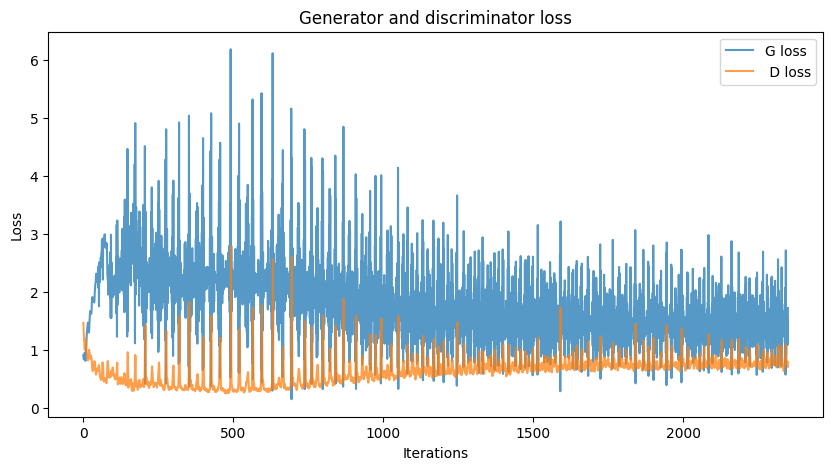

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator loss")
plt.plot(G_losses_sat,label="G loss", alpha=0.75)
plt.plot(D_losses_sat,label=" D loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Generator gradients mean and standard deviation versus training iteration**

Below is a plot of the G gradients mean and standard deviation versus training iterations.

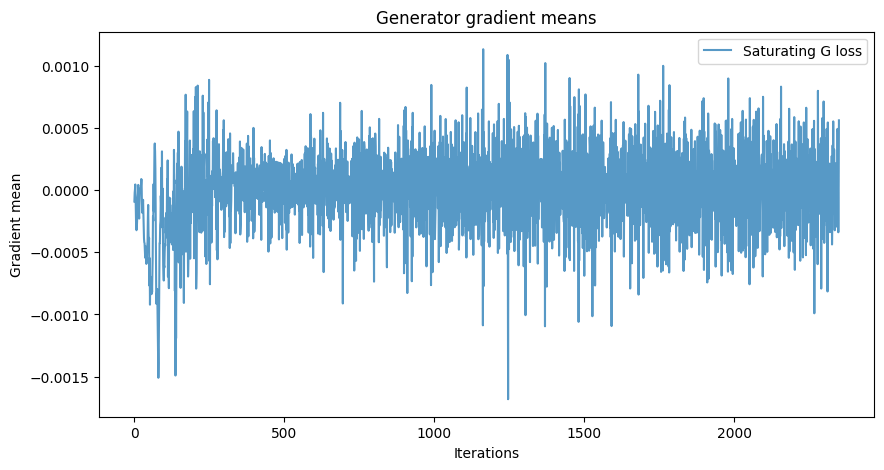

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator gradient means")
plt.plot(G_grads_mean_sat, label="Saturating G loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Gradient mean")
plt.legend()
plt.show()

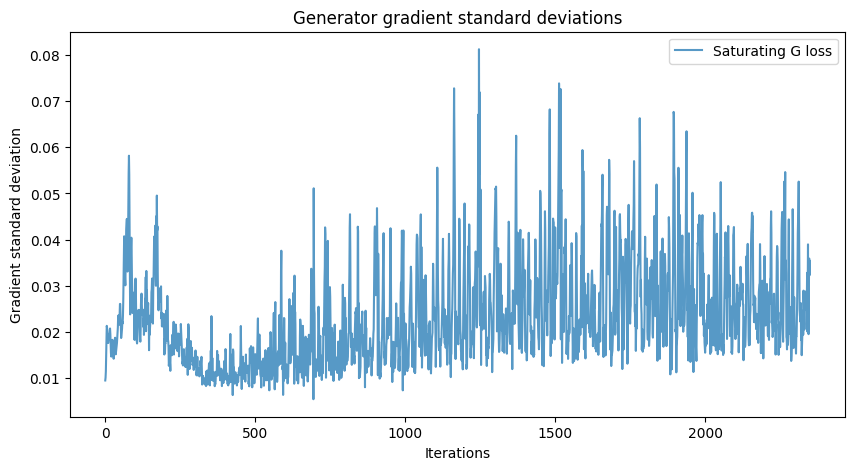

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator gradient standard deviations")
plt.plot(G_grads_std_sat,label="Saturating G loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Gradient standard deviation")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




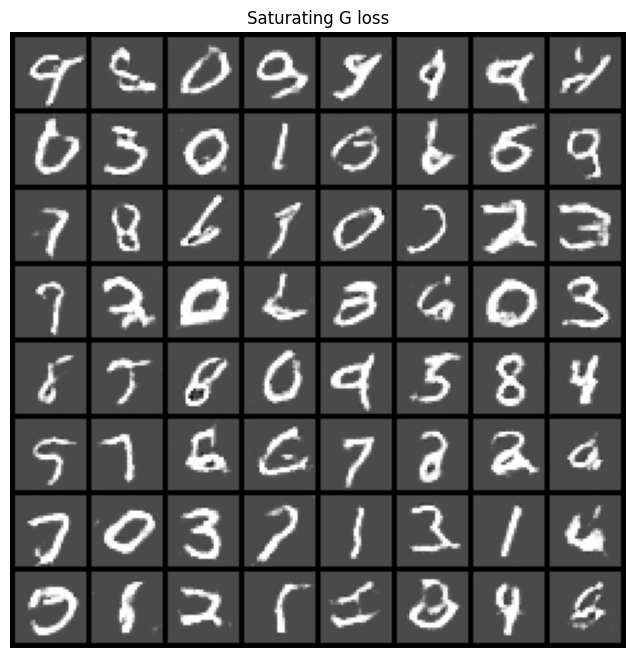

In [ ]:
# Visualize results with G loss
fig = plt.figure(figsize=(8,8))
plt.title('G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_sat]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




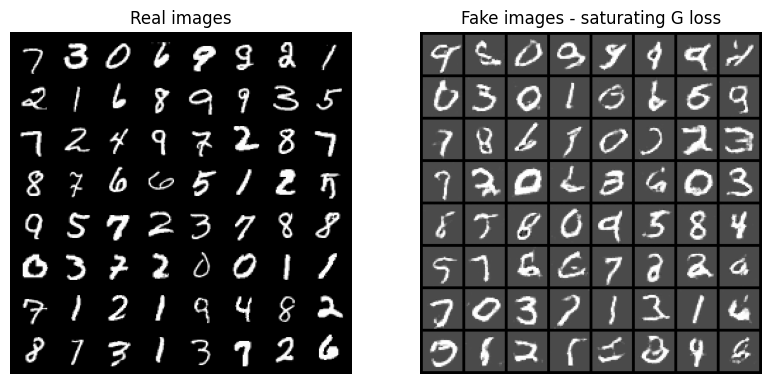

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Fake images - saturating G loss")
plt.imshow(np.transpose(img_list_sat[-1],(1,2,0)))

plt.show()

# Training with the Lighning trainer

In [ ]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.0 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from torchvision.utils import save_image


In [ ]:
import os
import torchvision.utils as vutils

class GANLightningModule(pl.LightningModule):
    def __init__(self, generator, discriminator, dataloader, lr, beta1, nz, fixed_noise, ngpu):
        super().__init__()
        self.save_hyperparameters()

        self.generator = generator(ngpu)
        self.discriminator = discriminator(ngpu)
        self.criterion = nn.BCEWithLogitsLoss()
        self.fixed_noise = fixed_noise  # Fixed latent noise for consistent image generation
        self.automatic_optimization = False
        self.generated_images = []  # Store generated images for saving and visualization
        self.dataloader = dataloader

    def forward(self, z):
        """Generate images given latent noise."""
        return self.generator(z)

    def configure_optimizers(self):
        """Set up optimizers for both Generator and Discriminator."""
        optimizerD = optim.Adam(self.discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))
        optimizerG = optim.Adam(self.generator.parameters(), lr=0.002, betas=(0.5, 0.999))
        return [optimizerD, optimizerG], []

    def training_step(self, batch, batch_idx):
        """Single step in the training loop."""
        real_images = batch[0]
        b_size = real_images.size(0)
        device = real_images.device

        # Get optimizers
        optimizerD, optimizerG = self.optimizers()

        # Real and fake labels
        real_label = torch.ones(b_size, device=device)
        fake_label = torch.zeros(b_size, device=device)

        # -----------------------------
        # (1) Train Discriminator
        # -----------------------------
        optimizerD.zero_grad()
        real_output = self.discriminator(real_images).view(-1)
        errD_real = self.criterion(real_output, real_label)

        noise = torch.randn(b_size, self.hparams.nz, 1, 1, device=device)
        fake_images = self.generator(noise).detach()
        fake_output = self.discriminator(fake_images).view(-1)
        errD_fake = self.criterion(fake_output, fake_label)

        errD = errD_real + errD_fake
        self.manual_backward(errD)
        optimizerD.step()

        # -----------------------------
        # (2) Train Generator
        # -----------------------------
        optimizerG.zero_grad()
        fake_images = self.generator(noise)
        output = self.discriminator(fake_images).view(-1)
        errG = self.criterion(output, real_label)

        self.manual_backward(errG)
        optimizerG.step()

        # Log losses
        self.log("Loss_D", errD, on_epoch=True, prog_bar=True, logger=True)
        self.log("Loss_G", errG, on_epoch=True, prog_bar=True, logger=True)

    def on_train_epoch_end(self):
        """Generate and store images at the end of each epoch."""
        with torch.no_grad():
            fake_images = self(self.fixed_noise).detach().cpu()
        grid = vutils.make_grid(fake_images, padding=2, normalize=True)
        self.generated_images.append(grid)

        print(f"Epoch {self.current_epoch} | Generated image grid added.")

        # Log generated images for visualization
        if self.logger:
            self.logger.experiment.add_image(f"Generated Images Epoch {self.current_epoch}", grid, self.current_epoch)

    def train_dataloader(self):
        """Return the DataLoader for training."""
        return self.dataloader

    def save_generated_images(self, output_dir="./generated_images"):
        """Save all generated images to disk after training."""
        if not self.generated_images:
            print("No generated images to save!")
            return

        os.makedirs(output_dir, exist_ok=True)
        for idx, img in enumerate(self.generated_images):
            vutils.save_image(img, os.path.join(output_dir, f"image_epoch_{idx}.png"))
        print(f"Generated images saved in {output_dir}")


In [ ]:
# Instantiate your models
netG = Generator
netD = Discriminator

# Fixed noise for image generation
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Define the GAN module
gan_module = GANLightningModule(
    generator=netG,
    discriminator=netD,
    dataloader=dataloader,
    lr=lr,
    beta1=beta1,
    nz=nz,
    fixed_noise=fixed_noise,
    ngpu=ngpu,
)

# Initialize a PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=num_epochs,
    devices=ngpu if torch.cuda.is_available() else 0,  # Use GPUs if available
)

# Train the model
trainer.fit(gan_module)
gan_module.save_generated_images()



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | generator     | Generator         | 600 K  | train
1 | discriminator | Discriminator     | 128 K  | train
2 | criterion     | BCEWithLogitsLoss | 0      | train
------------------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 | Generated image grid added.
Epoch 1 | Generated image grid added.
Epoch 2 | Generated image grid added.
Epoch 3 | Generated image grid added.
Epoch 4 | Generated image grid added.
Epoch 5 | Generated image grid added.
Epoch 6 | Generated image grid added.
Epoch 7 | Generated image grid added.
Epoch 8 | Generated image grid added.
Epoch 9 | Generated image grid added.


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Generated images saved in ./generated_images


In [ ]:
gan_module.save_generated_images()


Generated images saved in ./generated_images


# Display Result

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import numpy as np


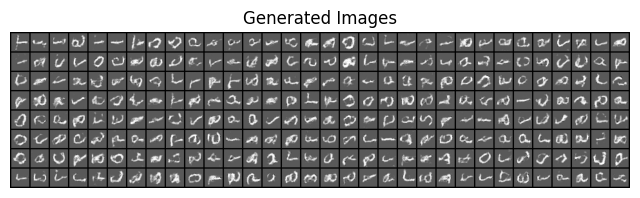

In [ ]:

image_folder = 'generated_images'
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_list = []

for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    img = Image.open(image_path)
    img_np = np.array(img) # Convert PIL Image to NumPy array
    image_list.append(img_np)

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")

ims = [[plt.imshow(np.transpose(i, (1, 0, 2)), animated=True)] for i in image_list]

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())